<class 'pandas.core.frame.DataFrame'>
Index: 14054 entries, 0 to 15074
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   event_date                  14054 non-null  datetime64[ns]
 1   year                        14054 non-null  int64         
 2   month                       14054 non-null  int32         
 3   day                         14054 non-null  int32         
 4   event_type                  14054 non-null  object        
 5   country                     14054 non-null  object        
 6   admin1                      14054 non-null  object        
 7   fatalities                  14054 non-null  int64         
 8   actor1_type                 14054 non-null  object        
 9   actor2_type                 13362 non-null  object        
 10  interaction_type            14054 non-null  object        
 11  is_terrorist_group_related  14054 non-null  int64         


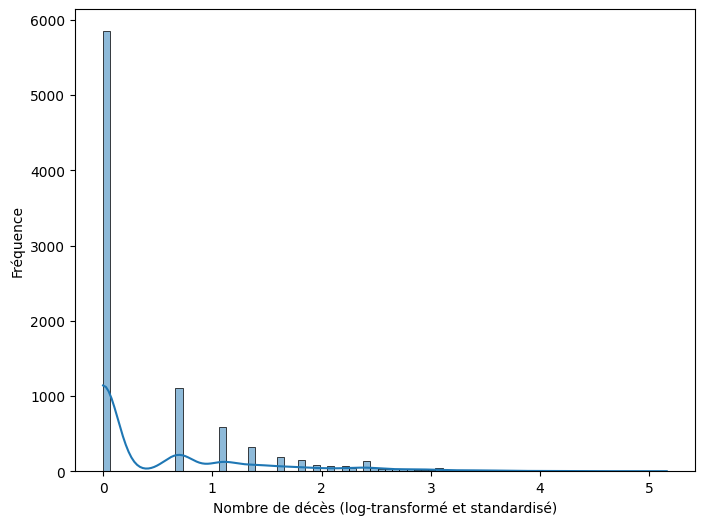

In [20]:
############################################################
## CHARGEMENT DES BIBLIOTHEQUES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from umap import UMAP


############################################################
## FONCTIONS UTILES

# Fonction qui permet de charger un fichier json dans un dictionnaire
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data


############################################################
## CHARGEMENT DU DATAFRAME

# On charge les données dans un dataframe "df"
df = pd.read_csv('../data/raw/terrorisme_sahel.csv')


############################################################
## FILTRAGE DE COLONNES

# On récupère ici seulement les évènements qui nous intéressent, ceux liés à des violences politiques
events_filter = ['Battles', 'Explosions/Remote violence',
                 'Violence against civilians', 'Strategic developments']

df = df[df['event_type'].isin(events_filter)]


############################################################
## CREATION DE NOUVELLES COLONNES

# On transforme la colonne "event_date" en datetime pour la manipuler plus facilement
df['event_date'] = pd.to_datetime(df['event_date'])

# On crée la colonne "month" en utilisant l'attribut month de datetime
df['month'] = df['event_date'].dt.month
# On ajoute la colonne juste après "year"
df.insert(3, 'month', df.pop('month'))

# On crée la colonne "day" en utilisant l'attribut day de datetime
df['day'] = df['event_date'].dt.day
# On ajoute la colonne juste après "month"
df.insert(5, 'day', df.pop('day'))


##
# On charge les données du fichier json "actor_type" dans un dictionnaire
# qui associe les valeurs des colonnes "inter1" et "inter2"
# au nom de chaque catégorie d'acteur (source : codebook ACLED)
actor_type = load_json_file("../references/actor_type.json")

# On convertit les clés du dictionnaire en entiers
actor_type = {int(k): v for k, v in actor_type.items()}

# On ajoute les colonnes "actor1_type" et "actor2_type" au dataframe
df['actor1_type'] = df['inter1'].map(actor_type)
df['actor2_type'] = df['inter2'].map(actor_type)


##
# On charge les données du fichier json "interaction_type" dans un dictionnaire
# associant aux valeurs de la colonne "interaction"
# les 2 acteurs impliqués dans une confrontation (source : codebook ACLED)
interaction_type = load_json_file("../references/interaction_type.json")

# On convertit les clés du dictionnaire en entiers
interaction_type = {int(k): v for k, v in interaction_type.items()}

# On ajoute une colonne "interaction_type" au dataframe
df['interaction_type'] = df['interaction'].map(interaction_type)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des
# acteurs est une organisation terroriste

##
# On charge les données du fichier json "terrorist_group_filiation"
# dans un dictionnaire associant organisation terroriste et organisation mère
terrorist_group_filiation = load_json_file("../references/terrorist_group_filiation.json")

# On crée une liste contenant les organisations terroristes à partir des indices de ce dictionnaire
terrorist_groups = list(terrorist_group_filiation.keys())

# On crée une fonction pour vérifier si un acteur est une organisation terroriste
def is_terrorist_actor(actor):
    return actor in terrorist_groups

# On ajoute la colonne "is_terrorist_group_related" au dataframe
df['is_terrorist_group_related'] = (df['actor1'].apply(is_terrorist_actor) |
                             df['assoc_actor_1'].apply(is_terrorist_actor) |
                             df['actor2'].apply(is_terrorist_actor) |
                             df['assoc_actor_2'].apply(is_terrorist_actor)).astype(int)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un
# des acteurs est une pmc russe
pmc_groups = ['Wagner Group']

# On crée une fonction pour vérifier si un acteur est une pmc russe
def is_pmc_actor(actor):
    return actor in pmc_groups

# On ajoute la colonne "is_pmc_related" au dataframe
df['is_pmc_related'] = (df['actor1'].apply(is_pmc_actor) |
                             df['assoc_actor_1'].apply(is_pmc_actor) |
                             df['actor2'].apply(is_pmc_actor) |
                             df['assoc_actor_2'].apply(is_pmc_actor)).astype(int)


##
# On crée une fonction de mapping pour associer les valeurs du dictionnaire aux acteurs
# S'il n'y a pas de valeur on retourne "None" car cela veut simplement dire que l'évènement
# n'est pas lié à une organisation terroriste
def map_filiation(row):
    for actor in ['actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2']:
        if row[actor] in terrorist_group_filiation:
            return terrorist_group_filiation[row[actor]]
    return "None"

# On ajoute la colonne "terrorist_group_filiation" au dataframe
df['terrorist_group_filiation'] = df.apply(map_filiation, axis=1)


############################################################
## SUPPRESSION DE COLONNES

# On supprime les colonnes qui ne nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'disorder_type',
    'sub_event_type',
    'actor1',
    'assoc_actor_1',
    'actor2',
    'assoc_actor_2',
    'inter1',
    'inter2',
    'interaction',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting',
    'event_id_cnty'
]

df = df.drop(columns=columns_to_drop, axis=1)


############################################################
## GESTION DES VALEURS MANQUANTES

# On affiche les valeurs manquantes dans les colonnes restantes
df.info()

# Pour la colonne "actor2_type" on va remplacer les valeurs manquantes par "None" car cela
# indique juste que dans certains cas qu'il y a un seul acteur et pas un manque de valeur
df['actor2_type'] = df['actor2_type'].fillna("None")

# On affiche une première description statistique des variables
df.describe()
# On constate que les stats obtenues semblent correctes exceptée la valeur max pour la variable
# fatalities, ce qui peut indiquer tout simplement une journée très meurtrière.

# On récupère la ligne en question
df[df['fatalities'] == 179]
# Grâce à la date et aux autres infos (acteurs), on peut consulter l'actualité à cette époque
# et se rendre compte que cela correspond à un massacre qui a été perpétré par les forces Burkina
# contre des civils. On décidera de conserver cette valeur qui correspond à un évènement important
# qui peut avoir un impact sur notre analyse, mais pour réduire son impact sur les autres features,
# on fera une transformation logarithmique.


############################################################
## TRANSFORMATION DES DONNEES

# On trie notre dataframe par "event_date" par ordre croissant
# pour que les données de test concernent les événements les plus récents
df = df.sort_values(by='event_date', ascending=True)

# Séparation des variables explicatives de notre variable cible
X = df.drop(columns=['event_date', 'day', 'is_terrorist_group_related', 'terrorist_group_filiation'], axis=1)
y = df['is_terrorist_group_related']

#####on se place comme si nous étions en novembre 2023 et que nous voulions prédire les données des mois à venir#########

# Division en ensembles d'entraînement et de test avec shuffle à False
# pour que les données de test concernent les événements les plus récents
# ce qui est nomée X_futur si on se place en novembre 2023 correspondent aux événements qui auront lieu de novembre 2023 à avril 2024
X_passe, X_futur, y_passe, y_futur = train_test_split(X, y, test_size=0.2, random_state=123, shuffle = False)

#Renomage pour une meilleure comprehension
#X_train_temp= X_passe
#X_test = X_futur
#X_valid = X_test
#X_train = X_train
#y_train_temp = y_passe
#y_test = y_futur
#y_valid = y_test
#y_train = y_train


#2eme découpage des données en respectant la chronologie. On va évaluer le modèle en faisant un nouveau découpage de X_passe, y_passe
X_train, X_test, y_train, y_test = train_test_split(X_passe, y_passe, test_size=0.2, random_state=123, shuffle = False)

# Hot One Encoding des variables catégorielles après le split
cat_columns = ['event_type', 'country', 'admin1', 'actor1_type', 'actor2_type', 'interaction_type']
X_train_encoded = pd.get_dummies(X_train, columns=cat_columns, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=cat_columns, dtype=int)
# On aligne les colonnes de X_test_encoded sur celles de X_train_encoded
# pour s'assurer qu'ils ont les mêmes colonnes
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# dichotmisation des variables cathégorielles pour X_passe et X_futur
cat_columns = ['event_type', 'country', 'admin1', 'actor1_type', 'actor2_type', 'interaction_type']
X_passe_encoded = pd.get_dummies(X_passe, columns=cat_columns, dtype=int)
X_futur_encoded = pd.get_dummies(X_futur, columns=cat_columns, dtype=int)
# On aligne les colonnes de X_passe sur celles de X_futur
# pour s'assurer qu'ils ont les mêmes colonnes
X_futur_encoded = X_futur_encoded.reindex(columns=X_passe_encoded.columns, fill_value=0)


# On effectue une transformation logarithmique (avec log1p pour gérer les valeurs de fatalities à 0)
X_train_encoded['fatalities'] = np.log1p(X_train_encoded['fatalities'])
X_test_encoded['fatalities'] = np.log1p(X_test_encoded['fatalities'])
X_passe_encoded['fatalities'] = np.log1p(X_passe_encoded['fatalities'])
X_futur_encoded['fatalities'] = np.log1p(X_futur_encoded['fatalities'])
# On vérifie visuellement que la transformation a eu l'effet souhaité sur la distribution des valeurs
plt.figure(figsize=(8, 6))
sns.histplot(X_train_encoded['fatalities'], kde=True)
plt.xlabel('Nombre de décès (log-transformé et standardisé)')
plt.ylabel('Fréquence')

# Initialisation d'un scaler pour les colonnes "month", "year" et "fatalities"
scaler = StandardScaler()
# On ajuste le scaler sur les données d'entraînement et on transforme les données d'entraînement et de test
X_train_encoded[['year', 'month', 'fatalities']] = scaler.fit_transform(X_train_encoded[['year', 'month', 'fatalities']])
X_test_encoded[['year', 'month', 'fatalities']] = scaler.transform(X_test_encoded[['year', 'month', 'fatalities']])
X_passe_encoded[['year', 'month', 'fatalities']] = scaler.fit_transform(X_passe_encoded[['year', 'month', 'fatalities']])
X_futur_encoded[['year', 'month', 'fatalities']] = scaler.transform(X_futur_encoded[['year', 'month', 'fatalities']])

# Transformation de la colonne 'month' sur les données d'entraînement et de test
X_train_encoded['month_sin'] = np.sin(2 * np.pi * X_train_encoded['month'] / 12)
X_train_encoded['month_cos'] = np.cos(2 * np.pi * X_train_encoded['month'] / 12)
X_test_encoded['month_sin'] = np.sin(2 * np.pi * X_test_encoded['month'] / 12)
X_test_encoded['month_cos'] = np.cos(2 * np.pi * X_test_encoded['month'] / 12)
X_passe_encoded['month_sin'] = np.sin(2 * np.pi * X_passe_encoded['month'] / 12)
X_passe_encoded['month_cos'] = np.cos(2 * np.pi * X_passe_encoded['month'] / 12)
X_futur_encoded['month_sin'] = np.sin(2 * np.pi * X_futur_encoded['month'] / 12)
X_futur_encoded['month_cos'] = np.cos(2 * np.pi * X_futur_encoded['month'] / 12)


# Suppression de la colonne 'month' après transformation
X_train_encoded = X_train_encoded.drop(columns=['month'])
X_test_encoded = X_test_encoded.drop(columns=['month'])
X_passe_encoded = X_passe_encoded.drop(columns=['month'])
X_futur_encoded = X_futur_encoded.drop(columns=['month'])


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [22]:
# instantiation de l'arbre de décision
dt_clf = DecisionTreeClassifier(criterion ='entropy', max_depth=4, random_state=123)
# entrainement sur X_train_encoded y_train_encoded
dt_clf.fit(X_train_encoded, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [23]:
y_pred = dt_clf.predict(X_test_encoded)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,530,20
1,3,1696


In [24]:
print('Score entrainement:', dt_clf.score(X_train_encoded, y_train))
print('Score de validation:', dt_clf.score(X_test_encoded, y_test))

Score entrainement: 0.9467422726261953
Score de validation: 0.989773232547799


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       550
           1       0.99      1.00      0.99      1699

    accuracy                           0.99      2249
   macro avg       0.99      0.98      0.99      2249
weighted avg       0.99      0.99      0.99      2249



In [26]:
# quelles sont les variables les plus importantes?
feats = {}
for feature, importance in zip(X_test_encoded.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

#Affichage des 12 variables les plus importantes
importances.sort_values(by='Importance', ascending=False).head(12)

,Importance
actor2_type_Rebel Groups,0.445740
actor1_type_Rebel Groups,0.380011
year,0.063094
admin1_Sahel,0.036600
month_sin,0.035328
admin1_Tillaberi,0.023333
admin1_Gao,0.005668
interaction_type_STATE FORCES VERSUS CIVILIANS,0.005119
admin1_Menaka,0.002624
interaction_type_REBELS VERSUS REBELS,0.001364


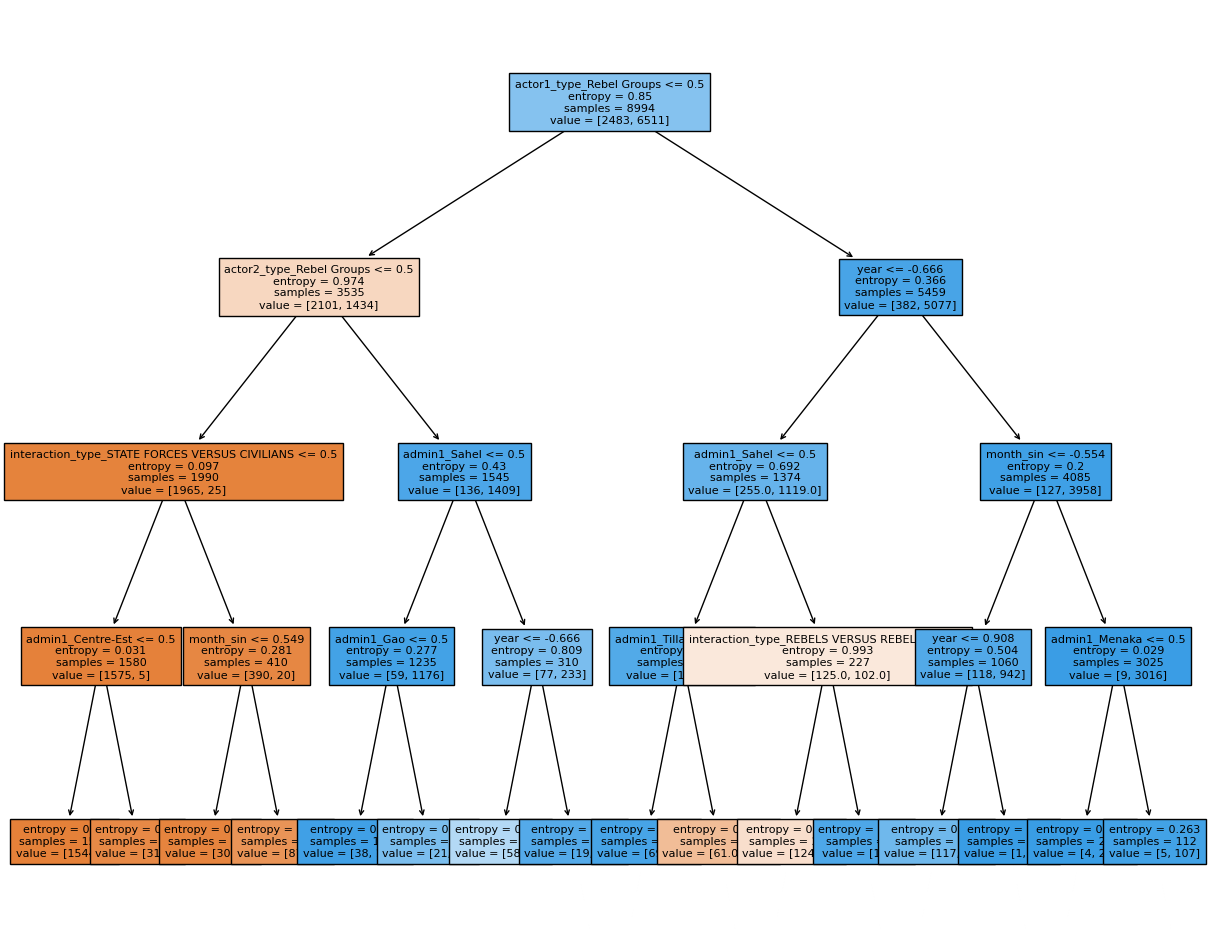

In [27]:
from sklearn import tree

# tracé de l'arbre de décision sur les données d'entrainement
plt.figure(figsize=(15,12))
tree.plot_tree(dt_clf, feature_names = X_train_encoded.columns.tolist(), filled=True, fontsize = 8);

In [28]:
# application du modéle en condition de prédiction réelle
# entrainement sur X_train_temp_encoded y_train
dt_clf.fit(X_passe_encoded, y_passe)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [29]:
y_pred_futur = dt_clf.predict(X_futur_encoded)
pd.crosstab(y_futur, y_pred_futur, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,723,1
1,10,2077


In [30]:
print(classification_report(y_futur, y_pred_futur))
# Les résultats sont très bons

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       1.00      1.00      1.00      2087

    accuracy                           1.00      2811
   macro avg       0.99      1.00      0.99      2811
weighted avg       1.00      1.00      1.00      2811



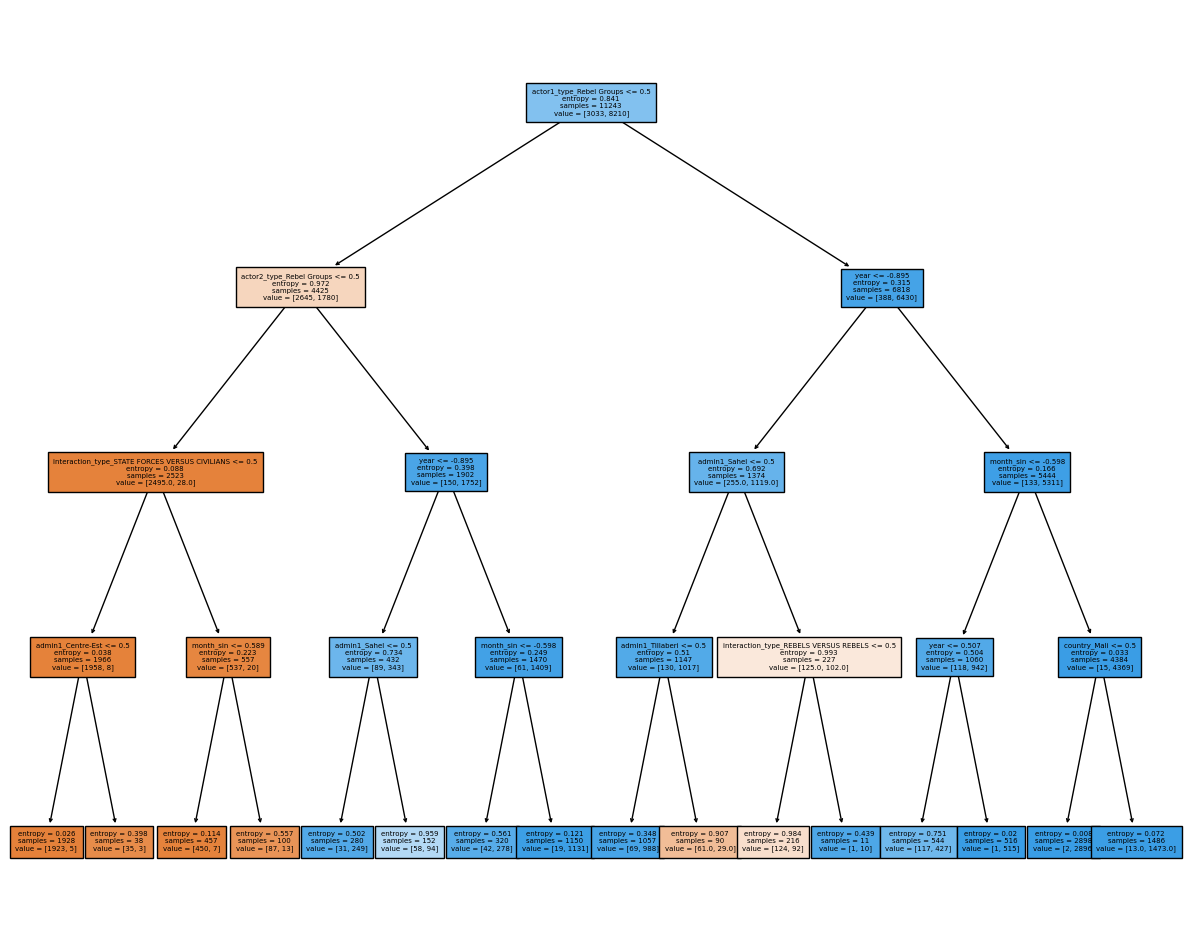

In [31]:
plt.figure(figsize=(15,12))
tree.plot_tree(dt_clf, feature_names = X_futur_encoded.columns.tolist(), filled=True, fontsize = 5);